In [ ]:
# INSTALAÇÃO DOS PACOTES E LIVRARIAS NECESSÁRIAS
%pip install langchain langchain_openai langchain_community neo4j pymupdf openai pandas sentence-transformers

In [17]:
import os
import json
import textwrap
import logging
import time
import fitz
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from openai import OpenAI
from sentence_transformers import SentenceTransformer,util
from langchain_community.graphs import Neo4jGraph
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.chains import RetrievalQAWithSourcesChain

# Global constants
CV_FOLDER = "CVs"
JD_FOLDER = "JDs"
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')
NEO4J_DATABASE = os.getenv('NEO4J_DATABASE') or 'neo4j'
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')


# Define a decorator to measure the execution time of functions
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"  - tempo de operação {end_time - start_time:.1f}s")
        return result
    return wrapper

In [ ]:
# Definição da ontologia para extração de CVs

# Tipos de entidades ou nós:
entity_types = {
  "curiculum": { "type": "string"},
  "person": { "type": "string" }, 
  "company": { "type": "string" },
  "position": { "type": "string" }, 
  "achievement": { "type": "string" },
  "place": { "type": "string" }, 
  "language": { "type": "string" }, 
  "school_or_university": { "type": "string" },
  "technology": { "type": "string" },
  "skill": { "type": "string" }
}

# Tipos de relacionamentos:
relation_types = {
  "describes": { "type": "string" },
  "worked_as": { "type": "string" }, 
  "studied_at": { "type": "string" }, 
  "has_achieved": { "type": "string" },
  "is_located_at": { "type": "string" }, 
  "speaks_or_understands": { "type": "string" }, 
  "has_studied": { "type": "string" },
  "has_worked_for": { "type": "string" },
  "has_skill": { "type": "string" }
 }

In [10]:
# Chave para acesso ao API da OepnAI
client = OpenAI(api_key=OPENAI_API_KEY)

#find first '[' and last ']' in string
# Esta função apenas verifica se o GPT retornou uma lista ou um text, transformando texto para lista
def find_brackets(string):
    first = 0
    for i in range(len(string)):
        if string[i] == '[' and first==0:
            first = i
        if string[i] == ']':
            last = i
    return first, last

# transform text to json
def text_to_json(text):
    json_data = json.loads(text)
    return json_data

def ajustar_output(output):
    if not isinstance(output, list):
        f, l = find_brackets(output)
        return text_to_json(output[f:l+1])
    return output

# Chamada ao GPT 3.5 Turbo
@timeit
def extract_information(text, file_name, model="gpt-4-turbo"):
   completion = client.chat.completions.create(
        model=model, # Gpt 3.5 é um excelente custo beneficio para este uso
        temperature=0, # Não queremos criatividade, apenas análise semântica
        messages=[
        {
            "role": "system",
            "content": system_prompt # Parâmetro para prompt
        },
        {
            "role": "user",
            "content": user_prompt.format(
              entity_types=entity_types,
              relation_types=relation_types,
              specification="Curriculo: ##" + file_name + "##\n\nContents:" + text
            ) # Parâmetros para composição do prompt
        }
        ]
    )

   return completion.choices[0].message.content, completion.usage.total_tokens

# Definição da função do assitente
system_prompt = """You are an expert agent specialized in analyzing curiculum vitae.
Your task is to identify the entities and relations requested with the user prompt, from a given aplicant.
You must generate the output in a JSON containing a list with JOSN objects having the following keys: "head", "head_type", "relation", "tail", and "tail_type".
The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt, the "head_type"
key must contain the type of the extracted head entity which must be one of the types from the provided user list,
the "relation" key must contain the type of relation between the "head" and the "tail", the "tail" key must represent the text of an
extracted entity which is the tail of the relation, and the "tail_type" key must contain the type of the tail entity. Attempt to extract as
many entities and relations as you can. And remember to translate entities to english, whenever some other language is used.
"""

# Definição da estrutura do prompt
user_prompt = """Based on the following example, extract entities and relations from the provided text.
Use the following entity types:

# ENTITY TYPES:
{entity_types}

Use the following relation types:
{relation_types}

--> Beginning of example

# Specification
"Curriculo: ##nome do arquivo.pdf##\n\nMARISA MONTE DOS MONTES \nControl and Automation Engineer \nWorkforce & Business Excellence \n \nProject Engineer at Siemens with 5+ years of experience in a global corporate. Skilled Business Excellence and resource availability \nmanagement agent with effective communication and management skills, with ability on distinct roles: Sales Operations, \nimplementation and maintenance of the Quality Management System and Management support on ADMS bids. \n \nWORK EXPERIENCE \nSiemens Brazil \nProject Engineer II \n \n \nAnalysis and planning of resource availability on complex projects considering risks \nlinked to allocation.  \nApplication of authoring method that aims ranking and prioritizing the implementation \nof projects. \nContinuous process improvement. \nProvision of valuable information to Business Excellence and Sales Operations in a \nnational and global matter. \nImplementation and maintenance of the Quality Management System and for the \nelaboration, verification, and coordination of process-oriented systems, including the \nidentification and implementation of improvements, to ensure the continuous \nenhancement of the quality management, in line with the established strategies. \nBid Technical Support\n \nManagement support on ADMS bids (one of which we were awarded), discussing \nrequirements internally with the team and with the customer, supporting estimating \ncosts and timeline, elaborating documentation, and contacting suppliers. Assisted \nProject Managers to ensure schedule and costs were met. Continuously finding and \nimproving processes. \nResponsible for training and administering, countrywide, the E2E browser-based \nsystem for managing bid requirements that allows integration between analysts, \nengineers, quality team members, sales, project managers and DevOps. \n \nOTHER \n \nIdeasRanker \nAuthoring method that aims ranking and easing choosing projects. \n \nScience Without Borders (Ciência Sem Fronteiras - CsF) \nOne year of Automation and Robotics Engineering in University of Pisa (Italy). \n \nActive member of Innovation Committee at Siemens \nSince 2018. \nSKILLS \n \nTechnical \nAgile \nJira \nMs Project \nOrbit* / Tableau \nPower BI  \nPolarion*: End-to-End – Requirements \nManagement \n* Siemens internal \nProfessional \nEffective Communication \nHighly organized \nInitiative-taking and dependable \nLeadership \nResult-driven \n \n \nEDUCATION \n \nMaster of Business Administration – \nMBA, Agile Project Management in \nEngineering and Industry 4.0 \nPontifical Catholic University of Paraná \n \nControl and Automation Engineer \nFederal Technological University of \nParaná \n \n \nLANGUAGES \n \nPortuguese (Native) \nEnglish (Advanced) \nItalian (Advanced) \nFrench (Beginner) \n \n \nJanuary 2018 – August 2022 \nFebruary 2020 - Current \n \n+55 41 999801805 \n \nleticiadegg@gmail.com \n \nlinkedin.com/in/leticiagraziano/ \n Brazil, Curitiba \n \n"

################

# Output
[
  {{
    "head": "nome do arquivo.pdf",
    "head_type": "curiculum",
    "relation": "describes",
    "tail": "MARISA MONTE DOS MONTES",
    "tail_type": "person"
  }}
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "worked_as",
    "tail": "Control and Automation Engineer",
    "tail_type": "position"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "worked_as",
    "tail": "Workforce & Business Excellence",
    "tail_type": "position"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_worked_for",
    "tail": "Siemens",
    "tail_type": "company"
  }},
  {{
    "head": "Siemens",
    "head_type": "company",
    "relation": "is_located_at",
    "tail": "Brazil",
    "tail_type": "place"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "worked_as",
    "tail": "Project Engineer II",
    "tail_type": "position"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_achieved",
    "tail": "Analysis and planning of resource availability on complex projects considering risks linked to allocation.",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_achieved",
    "tail": "Application of authoring method that aims ranking and prioritizing the implementation of projects",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_achieved",
    "tail": "Continuous process improvement",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_achieved",
    "tail": "Provision of valuable information to Business Excellence and Sales Operations in a national and global matter.",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_achieved",
    "tail": "Implementation and maintenance of the Quality Management System and for the elaboration, verification, and coordination of process-oriented systems, including the identification and implementation of improvements, to ensure the continuous enhancement of the quality management, in line with the established strategies.",
    "tail_type": "achievement"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "speaks_or_understands",
    "tail": "Portuguese",
    "tail_type": "language"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "speaks_or_understands",
    "tail": "English",
    "tail_type": "language"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "speaks_or_understands",
    "tail": "Italian",
    "tail_type": "language"
  }},
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_skill",
    "tail": "Management",
    "tail_type": "language"
  }}
  {{
    "head": "MARISA MONTE DOS MONTES",
    "head_type": "person",
    "relation": "has_skill",
    "tail": "Agile",
    "tail_type": "language"
  }}
]

--> End of example

For the following specification, generate extract entitites and relations as in the provided example.

# Specification
{specification}
################

# Output

"""

In [ ]:
# Aqui executamos a ingestão da dados.
# Abrir PDF contido no diretório, extrair seus textos e chamar a função do GPT para a extração da informação

relacoes = []
pdf_files = [f for f in os.listdir(CV_FOLDER) if f.endswith('.pdf')]
for file in pdf_files:
    print("Parsing", file)
    with fitz.open(CV_Folder + "/" + file) as doc:  # open document
        cv = chr(12).join([page.get_text() for page in doc])
    try:
        extracted_relations, tokens_used = extract_information(cv, file)
        extracted_relations = ajustar_output(extracted_relations)
        relacoes.extend(extracted_relations)
        print("  - Parsing OK -" + str(tokens_used) + " tokens consumidos")
    except Exception as e:
        print("  - ERRO")
        logging.error(e)

#sALVAR RELACOES EM DF PARA LIMPEZA E VERIFICAÇÃO
kg_df = pd.DataFrame(relacoes)

Parsing Antonio Fagundes CVi.pdf
  - tempo de operação 47.4s
  - Parsing OK -3382 tokens consumidos
Parsing CV Elis Regina.pdf
  - tempo de operação 67.1s
  - Parsing OK -3761 tokens consumidos
Parsing CV Joao Silva 2022.pdf
  - tempo de operação 41.4s
  - Parsing OK -4080 tokens consumidos
Parsing CV Maria Betânia at.pdf
  - tempo de operação 71.0s
  - Parsing OK -4752 tokens consumidos
Parsing CV Nicholas Arand EN - 2022.pdf
  - tempo de operação 49.7s
  - Parsing OK -3808 tokens consumidos
Parsing Raimundo Fagner.pdf
  - tempo de operação 55.5s
  - Parsing OK -4275 tokens consumidos


In [ ]:
#Identificar pares de entidades para eliminar ambiguidades

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
def find_pairs(lista, th):
    pairs = []
    unicos = list(set(lista))
    embeddings = embedding_model.encode(unicos)
    for i in range(len(unicos)):
        for j in range(i + 1, len(unicos)):
            if util.cos_sim(embeddings[i], embeddings[j]) > th:
                pairs.append((unicos[i], unicos[j]))
    return pairs

pares = find_pairs(kg_df['tail'].values, 0.7)
pares

[('Spanish', 'English'),
 ('Federal Technological University of Paraná',
  'Universidade Federal do Paraná'),
 ('Federal Technological University of Paraná',
  'Pontifícia Universidade Católica do Paraná – PUC/PR'),
 ('Federal Technological University of Paraná',
  'Federal University of Paraná'),
 ('Quality Manager', 'Quality Analyst'),
 ('Quality Manager', 'Production and Quality Manager'),
 ('Quality Manager', 'Production and Quality Coordinator'),
 ('Quality Manager', 'Quality Management'),
 ('Implementation and maintenance of the Quality Management System and for the elaboration, verification, and coordination of process-oriented systems, including the identification and implementation of improvements, to ensure the continuous enhancement of the quality management, in line with the established strategies.',
  'Quality Management'),
 ('Mechanical Engineer', 'Industrial Engineer'),
 ('Mechanical Engineer', 'Chemical Engineer'),
 ('Industrial Engineer', 'Chemical Engineer'),
 ('Produ

In [ ]:
#RESOLVER AMBIGUIDADES (ESCOLHER POR PROMPT)

to_clean = []
for i in range(len(pares)):
    result = input(pares[i][0] + "   -   SAME AS   -   " + pares[i][1] + "    y/n" )
    if result == 'y':
        to_clean.append(1)
    elif result == 'n':
        to_clean.append(0)
    else:
        print("Error: input not valid")

# replace tail if is part of a pares
if len(to_clean) == len(pares):
    for par, test in zip(pares,to_clean):
        if test == 1:
            for i in range(len(kg_df)):
                if kg_df['tail'][i]==par[1]:
                    kg_df.loc[i,'tail']=par[0]
else:
    print("Error: len(to_clean) != len(pares)")

In [ ]:
# SALVAR ARQUIVOS

with open('relacoes.json', 'w') as f:
    json.dump(relacoes, f, indent=4)

kg_df.to_csv("sixcvs.csv")

In [12]:
#RECUPERAR ARQUIVOS

with open('relacoes.json', 'r') as f:
    relacoes = json.load(f)

kg_df = pd.read_csv("sixcvs.csv", index_col=0)

In [13]:
# Ao invés de utilizar a biblioteca networkx para gerar o grafo de conhecimento, vamos utilizar a base de dados neo4j, que
# além de ser muito mais poderosa, é integrável com o langchain, facilitando nossa vida.
# A má notícia é qe para "falar" com a base de dados, teremos que usar usa linguagem de trabalho que é a CYPHER.

kg = Neo4jGraph(url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD, database=NEO4J_DATABASE)

In [14]:
# CRIAR NA BASE DE DADOS NEO4J OS NODES E RELATIOSHIPS PARA DE NOSSO GRAPHO

for _, row in kg_df.iterrows():
    #heads
    cypher = 'MERGE (n: ' + row["head_type"] + ' { name: "' + row["head"] + '"}) ON CREATE SET n.name = "' + row["head"] +'"'
    kg.query(cypher)
    #tails
    cypher = 'MERGE (n: ' + row["tail_type"] + ' { name: "' + row["tail"] + '"}) ON CREATE SET n.name = "' + row["tail"] + '"'
    kg.query(cypher)
    #relations
    cypher = 'MATCH (e1:' + row["head_type"] + ' {name: "' + row["head"] + '"}), (e2:' + row["tail_type"] + ' {name: "' + row['tail'] + '"}) MERGE (e1)-[hasRelationship:' + row["relation"] + ']->(e2)'
    kg.query(cypher)


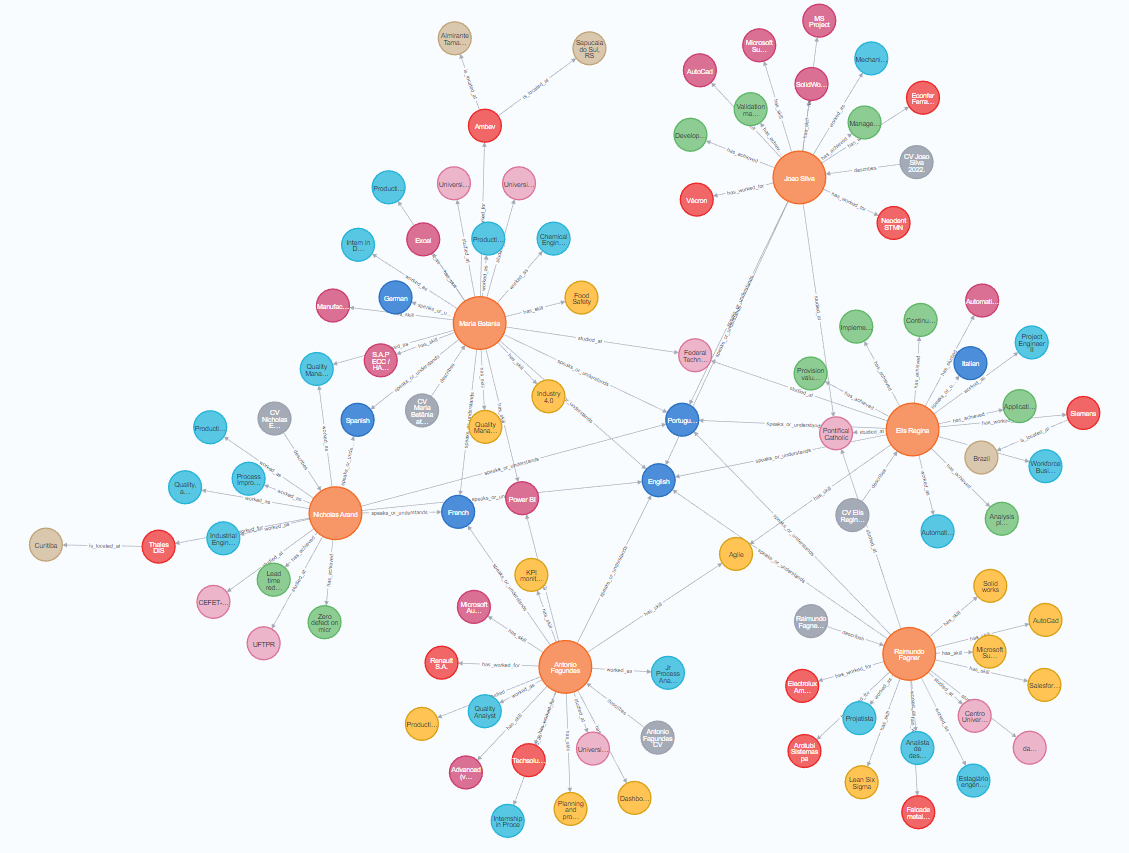

In [19]:
# Definição da ontologia para Descrições de Cargo

# Tipos de entidades ou nós:
entity_types = {
  "document": { "type": "string"},
  "job_description": { "type": "string" }, 
  "description": { "type": "string" }, 
  "resposibility": { "type": "string" },
  "required_skill": { "type": "string" }, 
  "required_education": { "type": "string" }
}

# Tipos de relacionamentos:
relation_types = {
  "contains": { "type": "string" },
  "describes": { "type": "string" },
  "implies":  { "type": "string" }, 
  "requires": { "type": "string" } 
 }

In [ ]:
# Chamada ao GPT 3.5 Turbo
@timeit
def extract_information(text, file_name, model="gpt-4-turbo"):
   completion = client.chat.completions.create(
        model=model, # Gpt 3.5 é um excelente custo beneficio para este uso
        temperature=0, # Não queremos criatividade, apenas análise semântica
        messages=[
        {
            "role": "system",
            "content": system_prompt # Parâmetro para prompt
        },
        {
            "role": "user",
            "content": user_prompt.format(
              entity_types=entity_types,
              relation_types=relation_types,
              specification="Job Description: ##" + file_name + "##\n\nContents:" + text
            ) # Parâmetros para composição do prompt
        }
        ]
    )

   return completion.choices[0].message.content, completion.usage.total_tokens

# Definição da função do assitente
system_prompt = """You are an expert agent specialized in analyzing Job Descriptions.
Your task is to identify the entities and relations requested with the user prompt for a given Job Description.
You must generate the output in a JSON containing a list with JOSN objects having the following keys: "head", "head_type", "relation", "tail", and "tail_type".
The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt, the "head_type"
key must contain the type of the extracted head entity which must be one of the types from the provided user list,
the "relation" key must contain the type of relation between the "head" and the "tail", the "tail" key must represent the text of an
extracted entity which is the tail of the relation, and the "tail_type" key must contain the type of the tail entity. Attempt to extract as
many entities and relations as you can.
"""

# Definição da estrutura do prompt
user_prompt = """Based on the following example, extract entities and relations from the provided text.
Use the following entity types:

# ENTITY TYPES:
{entity_types}

Use the following relation types:

# RELATION TYPES:
{relation_types}

--> Beginning of example

# Specification
"Job Description: ##nome do arquivo.pdf##\n\nProduction Manager Job Description\nJob Brief\nWe are looking for an experienced Production Manager to organize and oversee the\nmanufacturing of goods. As a Production Manager, you will be ultimately responsible\nfor the smooth running of all production lines and the quality of output. Your deep\nknowledge of production procedures and ability to direct personnel toward\nmaximum performance will set you apart as a leader. Decision-making and\nproblem-solving will be a significant part of your day. If you are up to the challenge,\nwe’d like to talk to you. The goal is to ensure an efficient and productive\nmanufacturing process that meets customer requirements.\nResponsibilities\n●\nLiaise with other managers to formulate objectives and understand\nrequirements\n○\nCollaborate with cross-functional teams to align production goals.\n○\nUnderstand project requirements and translate them into actionable\nplans.\n●\nEstimate costs and prepare budgets\n○\nAnalyze resource needs, material costs, and labor expenses.\n○\nDevelop and manage production budgets effectively.\n\nRequirements and Skills\n●\nProven experience as a production director\n○\nDemonstrated track record in managing production processes.\n○\nFamiliarity with manufacturing technologies.\n●\nDeep knowledge of production management\n○\nUnderstand production workflows, best practices, and efficiency\nimprovement strategies.\n●\nUnderstanding of quality standards and health & safety regulations\n○\nPrioritize safety and quality in all production activities.\n●\nExperience in reporting on key production metrics\n○\nAbility to analyze data and provide meaningful insights.\n●\nProficient in MS Office and ERP software\n○\nUtilize software tools for planning, reporting, and communication.\n●\nOutstanding communication ability\n○\nEffectively communicate with teams, stakeholders, and upper\nmanagement.\n●\nExcellent organizational and leadership skills\n○\nManage resources, timelines, and personnel effectively.\n●\nAttention to detail\n○\nEnsure accuracy and precision in production processes.\n●\nStrong decision-making skills and a results-driven approach\n○\nMake informed decisions to achieve production goals.\n●\nBSc/Ba in business administration or a relevant field is preferred\n"
################

# Output
[
  {{
    "head": "nome do arquivo.pdf",
    "head_type": "document",
    "relation": "describes",
    "tail": "Production Manager",
    "tail_type": "job_description"
  }}
    {{
    "head": "Organizes and oversees the\nmanufacturing of goods. Is ultimately responsible\nfor the smooth running of all production lines and the quality of output. Directs personel toward\nmaximum performance. Decision-making and\nproblem-solving is a significant part of the job. The goal is to ensure an efficient and productive\nmanufacturing process that meets customer requirements.",
    "head_type": "description",
    "relation": "describes",
    "tail": "Production Manager",
    "tail_type": "job_description"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "implies",
    "tail": "Liaise with other managers to formulate objectives and understand requirements",
    "tail_type": "responsibility"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "implies",
    "tail": "Collaborate with cross-functional teams to align production goals.",
    "tail_type": "responsibility"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "implies",
    "tail": "Understand project requirements and translate them into actionable plans.",
    "tail_type": "responsibility"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "implies",
    "tail": "Estimate costs and prepare budgets",
    "tail_type": "responsibility"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "implies",
    "tail": "Analyze resource needs, material costs, and labor expenses.",
    "tail_type": "responsibility"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "implies",
    "tail": "Develop and manage production budgets effectively",
    "tail_type": "responsibility"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "Process Management",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "Process Management",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "Production Managemen",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "Quality Standards",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "MS Office",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "ERP",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "Communication",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "Leadership",
    "tail_type": "required_skill"
  }}
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "English",
    "tail_type": "required_skill"
  }},
  {{
    "head": "Production Manager",
    "head_type": "job_description",
    "relation": "requires",
    "tail": "BSc/Ba in business administration",
    "tail_type": "required_education"
  }}
]

--> End of example

For the following specification, generate extract entitites and relations as in the provided example.

# Specification
{specification}
################

# Output
"""

In [ ]:
# Aqui executamos a ingestão da dados.
# Abrir PDF contido no diretório, extrair seus textos e chamar a função do GPT para a extração da informação

relacoes = []
pdf_files_jd = [f for f in os.listdir(JD_FOLDER) if f.endswith('.pdf')]
for file in pdf_files_jd:
    print("Parsing", file)
    with fitz.open(JD_FOLDER + "/" + file) as doc:  # open document
        cv = chr(12).join([page.get_text() for page in doc])
    try:
        extracted_relations, tokens_used = extract_information(cv, file)
        extracted_relations = ajustar_output(extracted_relations)
        relacoes.extend(extracted_relations)
        print("  - Parsing OK -" + str(tokens_used) + " tokens consumidos")
    except Exception as e:
        print("  - ERRO")
        logging.error(e)

#sALVAR RELACOES EM DF PARA LIMPEZA E VERIFICAÇÃO
kg_df_jd = pd.DataFrame(relacoes)

Parsing Process Engineer - Job Description.pdf
  - tempo de operação 30.6s
  - Parsing OK -2949 tokens consumidos
Parsing Project Manager - Job Description.pdf
  - tempo de operação 60.1s
  - Parsing OK -2699 tokens consumidos
Parsing Quality Engineer - Job Description.pdf
  - tempo de operação 30.0s
  - Parsing OK -2799 tokens consumidos


In [ ]:
# identify pairs of tails with cos similarity above 0.95
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
def find_pairs(lista, th):
    pairs = []
    unicos = list(set(lista))
    embeddings = embedding_model.encode(unicos)
    for i in range(len(unicos)):
        for j in range(i + 1, len(unicos)):
            if util.cos_sim(embeddings[i], embeddings[j]) > th:
                pairs.append((unicos[i], unicos[j]))
    return pairs

pares = find_pairs(kg_df_jd['tail'].values, 0.7)
pares

[('Ability to analyze and solve technical issues',
  'Identify technical issues and get to the root of the problem'),
 ('Technical knowledge in process engineering principles and methodologies',
  'Engineering knowledge related to manufacturing processes'),
 ('Perform process simulations and troubleshooting',
  'Creating process simulations and conducting risk assessments')]

In [ ]:
#RESOLVER AMBIGUIDADES (ESCOLHER POR PROMPT)

to_clean = []
for i in range(len(pares)):
    result = input(pares[i][0] + "   -   SAME AS   -   " + pares[i][1] + "    y/n" )
    if result == 'y':
        to_clean.append(1)
    elif result == 'n':
        to_clean.append(0)
    else:
        print("Error: input not valid")

# replace tail if is part of a pares
if len(to_clean) == len(pares):
    for par, test in zip(pares,to_clean):
        if test == 1:
            for i in range(len(kg_df_jd)):
                if kg_df_jd['tail'][i]==par[1]:
                    kg_df_jd.loc[i,'tail']=par[0]
else:
    print("Error: len(to_clean) != len(pares)")

In [ ]:
# SALVAR ARQUIVOS

with open('relacoes_jd.json', 'w') as f:
    json.dump(relacoes, f, indent=4)

kg_df_jd.to_csv("job_description.csv")

In [20]:
#RECUPERAR ARQUIVOS

with open('relacoes_jd.json', 'r') as f:
    relacoes = json.load(f)

kg_df_jd = pd.read_csv("job_description.csv", index_col=0)

In [22]:
for _, row in kg_df_jd.iterrows():
    #heads
    cypher = 'MERGE (n: ' + row["head_type"] + ' { name: "' + row["head"] + '"}) ON CREATE SET n.name = "' + row["head"] +'"'
    kg.query(cypher)
    #tails
    cypher = 'MERGE (n: ' + row["tail_type"] + ' { name: "' + row["tail"] + '"}) ON CREATE SET n.name = "' + row["tail"] + '"'
    kg.query(cypher)
    #relations
    cypher = 'MATCH (e1:' + row["head_type"] + ' {name: "' + row["head"] + '"}), (e2:' + row["tail_type"] + ' {name: "' + row['tail'] + '"}) MERGE (e1)-[hasRelationship:' + row["relation"] + ']->(e2)'
    kg.query(cypher)

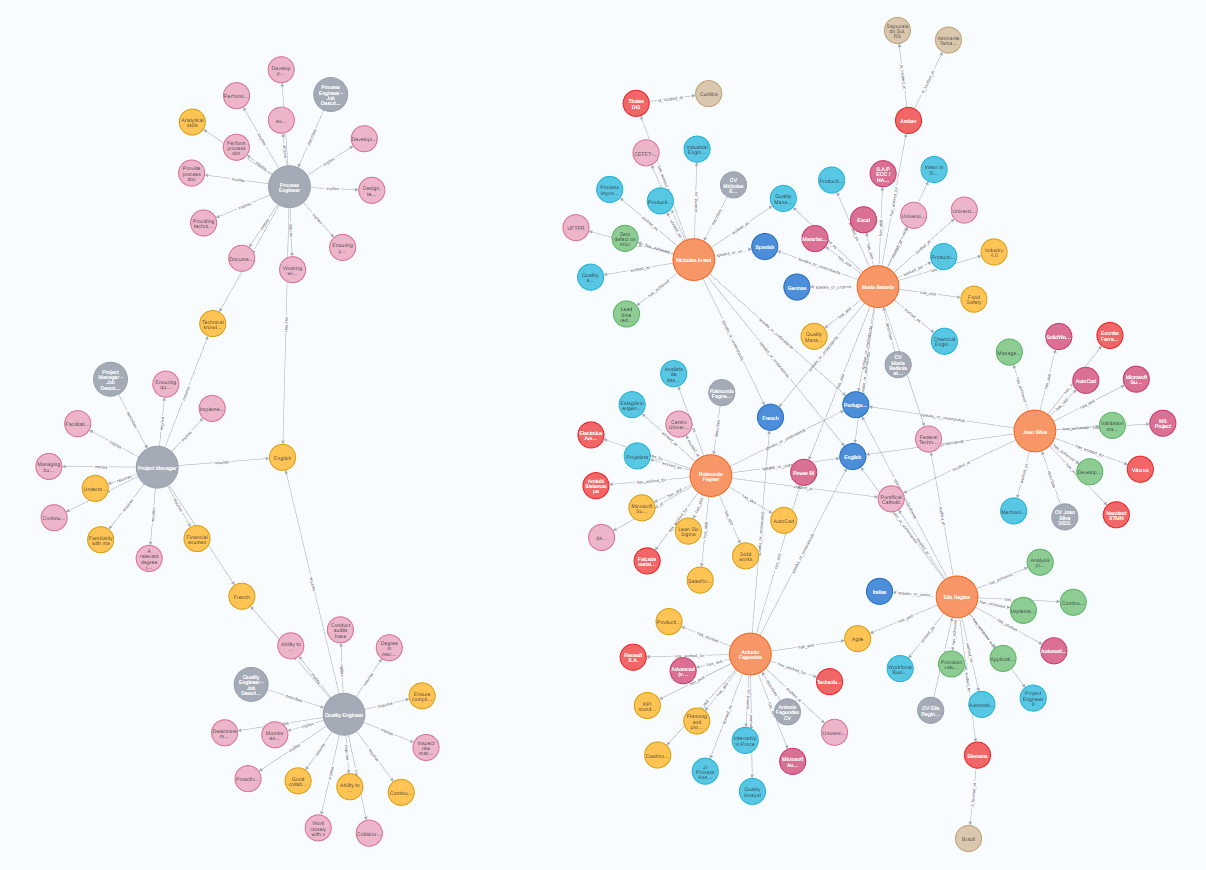

In [23]:
# Criar vector index para curriculos
def vectorize_nodes(vector_index_name, node_label):
  cypher = "CREATE VECTOR INDEX `" + vector_index_name + "` IF NOT EXISTS FOR (n:" + node_label + ") ON (n.nameEmbedding) OPTIONS { indexConfig: {`vector.dimensions`: 1536, `vector.similarity_function`: 'cosine'}}"
  kg.query(cypher)
  cypher = 'MATCH (n:' + node_label + ') WHERE n.nameEmbedding IS NULL WITH n, genai.vector.encode(n.name, "OpenAI", { token: $openAiApiKey}) AS vector CALL db.create.setNodeVectorProperty(n, "nameEmbedding", vector)'
  kg.query(cypher, params={"openAiApiKey":OPENAI_API_KEY})

In [24]:
# Criar indices verotiais para todos os nós de iteresse:

nodes_to_vectorize = ['responsibility', 'required_skill', 'education','position', 'language', 'skill', 'technology', 'achievement']
for node_type in nodes_to_vectorize:
    vectorize_nodes(node_type+'_idx', node_type)

In [26]:
# Encontrar "matches" entre JD e CV
# de um lado temos JD com responsibilities, required_skills e education
# de outro temos CV com skill, experience, position, technology, language, achievement
# vamos fazer buscas por similaridades e criar relações chamadas 99% match, 95% match, 90match...

jd_nodes = ['responsibility', 'required_skill', 'education']
cv_nodes = ['skill', 'experience', 'position', 'technology', 'achievement']
th = "0.93"
for jd_node in jd_nodes:
    for cv_node in cv_nodes:
            cypher = 'MATCH (n1:' + jd_node + '), (n2:' + cv_node + ') WHERE n1.nameEmbedding IS NOT NULL AND n2.nameEmbedding IS NOT NULL WITH n1, n2, vector.similarity.cosine(n1.nameEmbedding, n2.nameEmbedding) AS similarity WHERE similarity > ' + th + ' CREATE (n1)-[:matches]->(n2) RETURN n1.name, n2.name, similarity;' 
            result = kg.query(cypher)
            if len(result)>0:
                for r in result:
                    print(r['similarity'], r['n1.name']," ---> ", r['n2.name'])
        

0.9457615613937378 Managing project budget and resource allocation  --->  Analysis and planning of resource availability on complex projects considering risks linked to allocation.
0.9339704513549805 Evaluating existing manufacturing processes and identifying areas for improvement  --->  Continuous process improvement
0.9344031810760498 Performing process analysis and making recommendations for improvement  --->  Continuous process improvement
0.9530860781669617 Continuously evaluating and improving project processes and strategies  --->  Continuous process improvement
0.935122013092041 Technical knowledge in process engineering principles and methodologies  --->  Production Engineering
0.9354989528656006 Familiarity with manufacturing technologies  --->  Production Engineering
0.9495106935501099 Continuous learning  --->  Continuous process improvement
0.9306281805038452 A relevant degree (e.g., Bachelor’s or Master’s) in Engineering, Technical, Business, Manufacturing, Education, Pro

In [27]:
jd_nodes = ['required_skill']
cv_nodes = ['language']
th = "0.99"
for jd_node in jd_nodes:
    for cv_node in cv_nodes:
            cypher = 'MATCH (n1:' + jd_node + '), (n2:' + cv_node + ') WHERE n1.nameEmbedding IS NOT NULL AND n2.nameEmbedding IS NOT NULL WITH n1, n2, vector.similarity.cosine(n1.nameEmbedding, n2.nameEmbedding) AS similarity WHERE similarity > ' + th + ' CREATE (n1)-[:matches]->(n2) RETURN n1.name, n2.name, similarity;' 
            result = kg.query(cypher)
            if len(result)>0:
                for r in result:
                    print(r['similarity'], r['n1.name']," ---> ", r['n2.name'])

0.9999992847442627 French  --->  French
1.0 English  --->  English


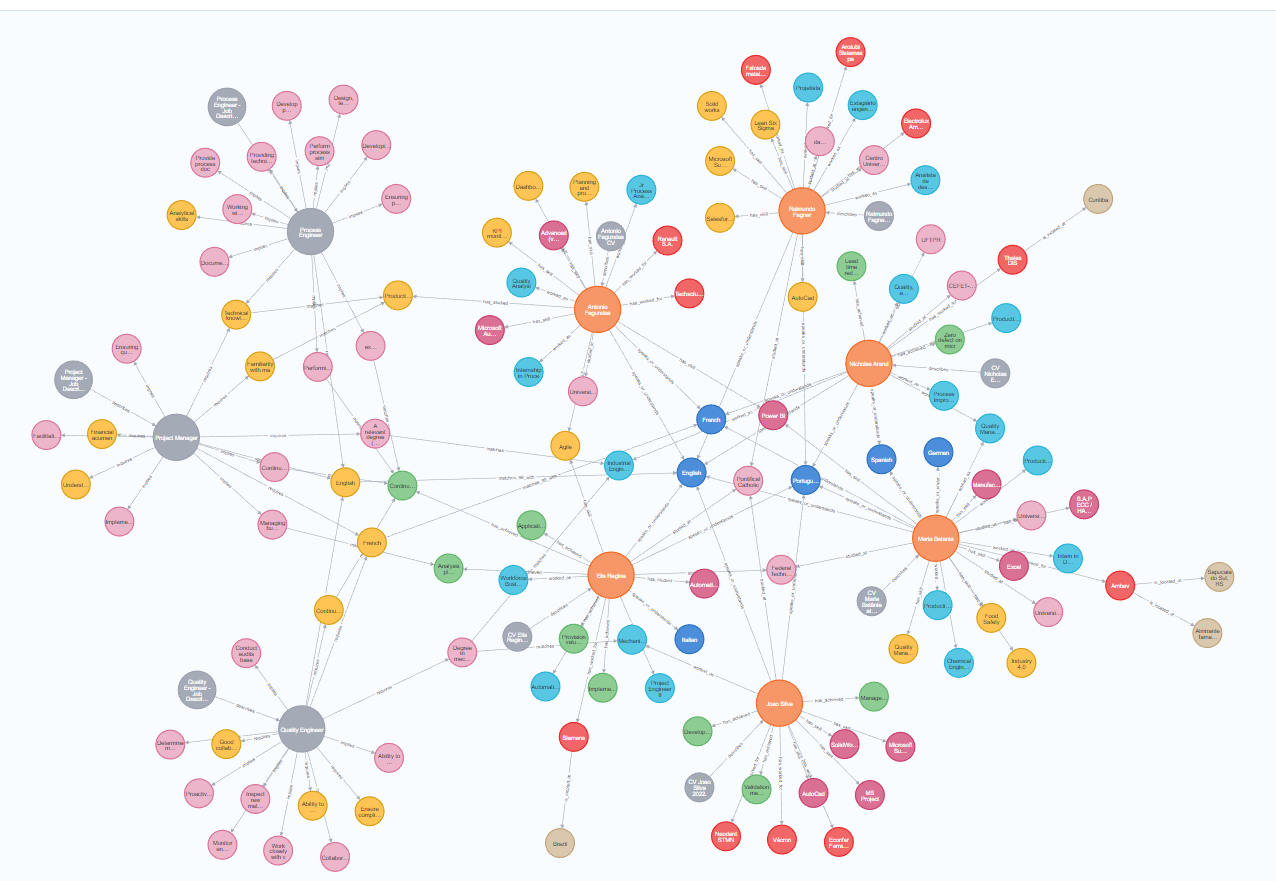

Alguns queries possiveis:

Se preciso contratar para a função de Gerente de Projetos:

MATCH (jd:job_description)-[r:requires]->(s) WHERE jd.name="Project Manager" RETURN jd,r,s
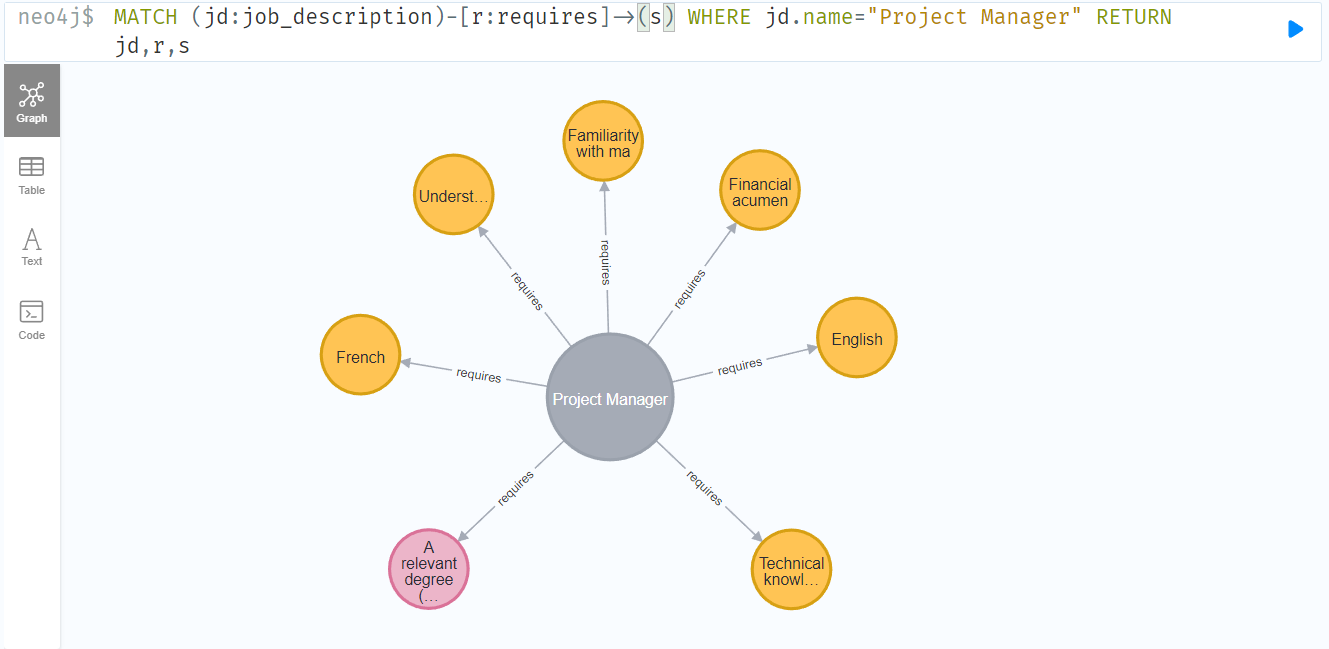

Dentre os requisitos para a função, quais possuem relação com habilidades de candidatos e quais os candidatos?
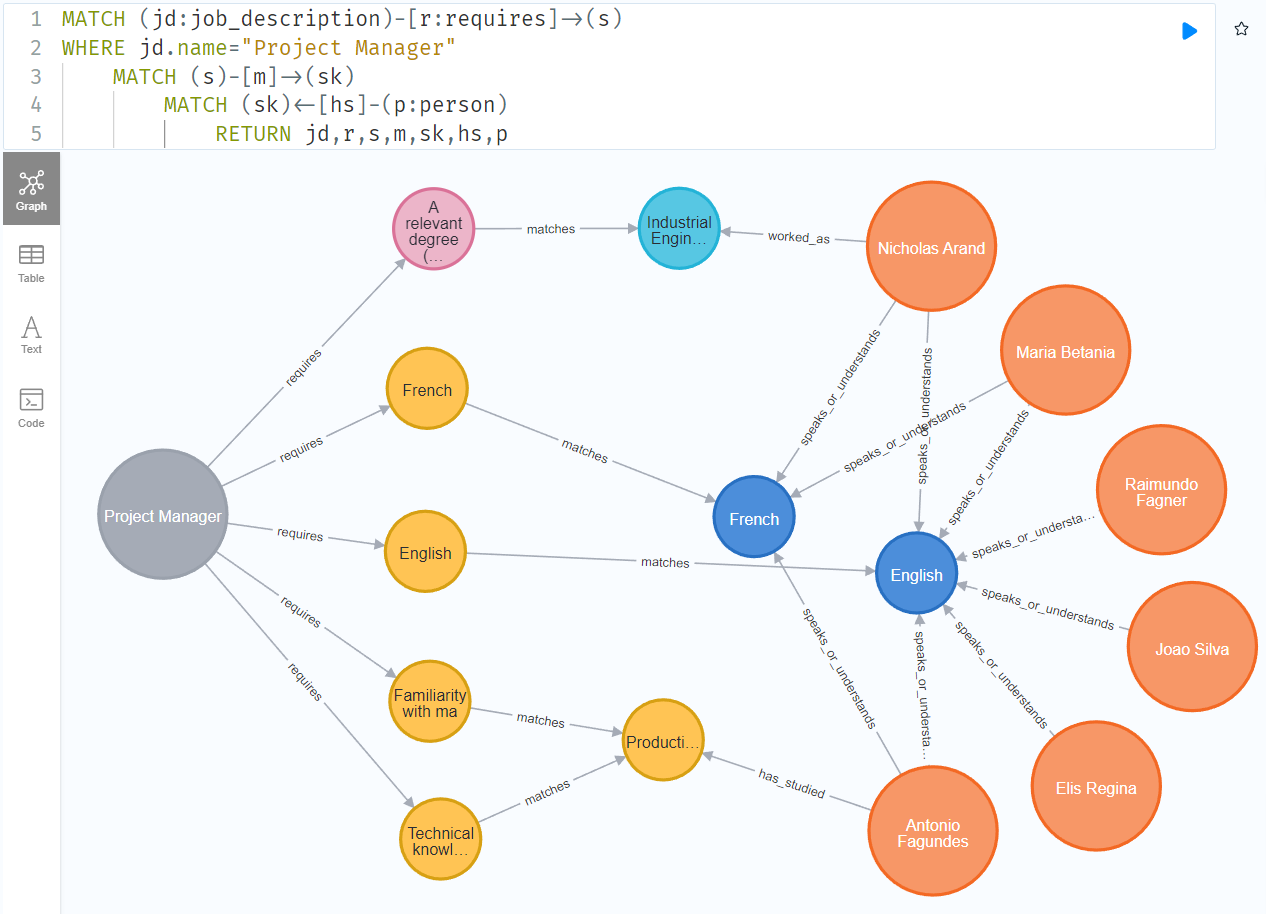

Podemos resumir em uma tabela?

In [41]:
result = kg.query("""
MATCH (jd:job_description)-[r:requires]->(s) 
WHERE jd.name="Project Manager" 
    MATCH (s)-[m]->(sk)
        MATCH (sk)<-[hs]-(p:person)
            RETURN p.name,type(hs),sk.name,type(m),s.name ORDER BY p.name
""")
result_df = pd.DataFrame(result)
result_df


,p.name,type(hs),sk.name,type(m),s.name
0,Antonio Fagundes,has_studied,Production Engineering,matches,Technical knowledge in process engineering pri...
1,Antonio Fagundes,speaks_or_understands,English,matches,English
2,Antonio Fagundes,has_studied,Production Engineering,matches,Familiarity with manufacturing technologies
3,Antonio Fagundes,speaks_or_understands,French,matches,French
4,Elis Regina,speaks_or_understands,English,matches,English
5,Joao Silva,speaks_or_understands,English,matches,English
6,Maria Betania,speaks_or_understands,English,matches,English
7,Maria Betania,speaks_or_understands,French,matches,French
8,Nicholas Arand,speaks_or_understands,English,matches,English
9,Nicholas Arand,speaks_or_understands,French,matches,French


In [43]:
result_df['p.name'].value_counts()

p.name
Antonio Fagundes    4
Nicholas Arand      3
Maria Betania       2
Elis Regina         1
Joao Silva          1
Raimundo Fagner     1
Name: count, dtype: int64

Para Engenheiro de Qualidade, não estranhamente, o Nicholas é o mis qualificado
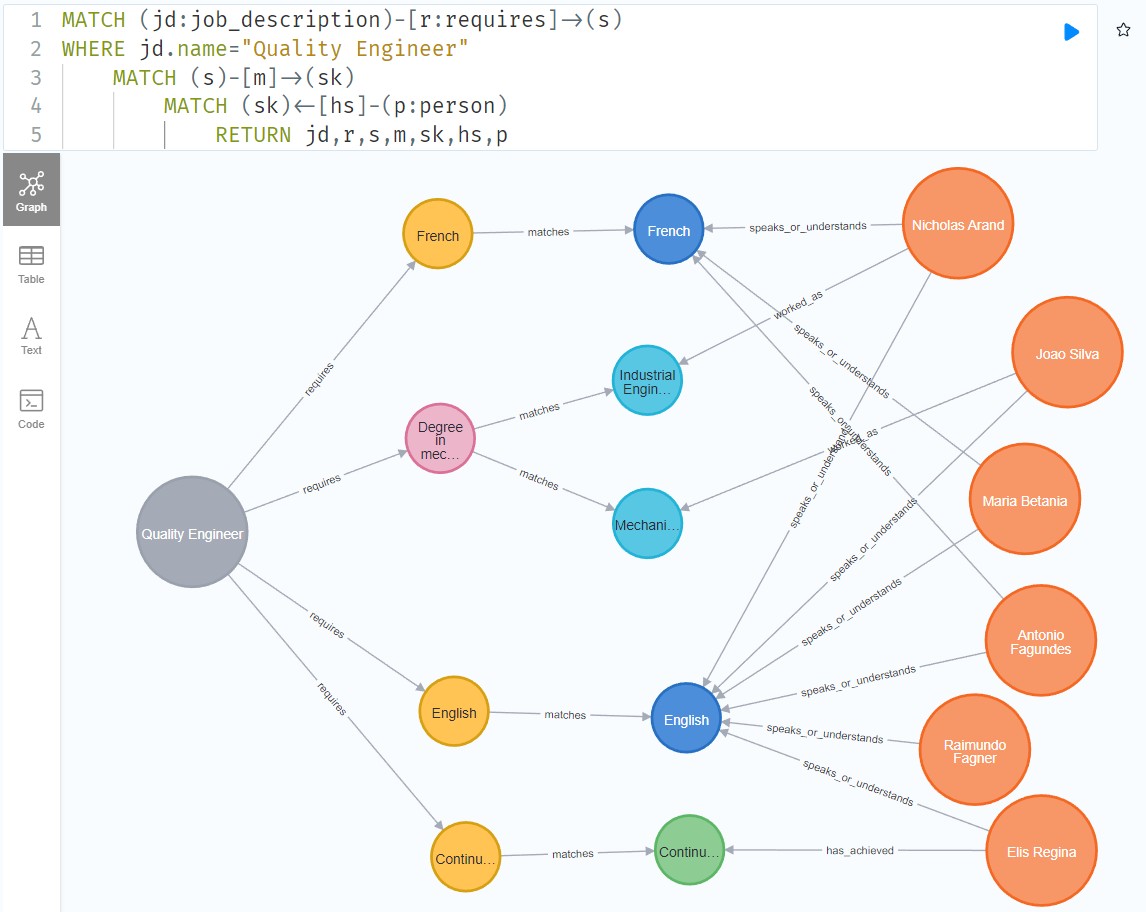

In [45]:
result = kg.query("""
MATCH (jd:job_description)-[r:requires]->(s) 
WHERE jd.name="Quality Engineer" 
    MATCH (s)-[m]->(sk)
        MATCH (sk)<-[hs]-(p:person)
            RETURN p.name,type(hs),sk.name,type(m),s.name ORDER BY p.name
""")
result_df = pd.DataFrame(result)
result_df

,p.name,type(hs),sk.name,type(m),s.name
0,Antonio Fagundes,speaks_or_understands,English,matches,English
1,Antonio Fagundes,speaks_or_understands,French,matches,French
2,Elis Regina,speaks_or_understands,English,matches,English
3,Elis Regina,has_achieved,Continuous process improvement,matches,Continuous learning
4,Joao Silva,speaks_or_understands,English,matches,English
5,Joao Silva,worked_as,Mechanical Engineer,matches,Degree in mechanical or industrial engineering
6,Maria Betania,speaks_or_understands,English,matches,English
7,Maria Betania,speaks_or_understands,French,matches,French
8,Nicholas Arand,speaks_or_understands,English,matches,English
9,Nicholas Arand,speaks_or_understands,French,matches,French


In [46]:
result_df['p.name'].value_counts()

p.name
Nicholas Arand      3
Antonio Fagundes    2
Elis Regina         2
Joao Silva          2
Maria Betania       2
Raimundo Fagner     1
Name: count, dtype: int64

In [58]:
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to 
query a graph database.
Instructions:
Use only the provided relationship types and properties in the 
schema. Do not use any other relationship types or properties that 
are not provided.
Schema:
{schema}
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than 
for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

Examples: Here are a few examples of generated Cypher statements for particular questions:

# Who is the most qualified candidate for the position of "Process Engineer"?
MATCH (jd:job_description)-[:requires]->(skills_requirements)-[matches]->(s)<-[t]-(p:person)
WHERE jd.name = "Quality Engineer"
WITH p.name AS personName, COUNT(*) AS occurrenceCount
RETURN personName, occurrenceCount
ORDER BY occurrenceCount DESC LIMIT 1

Notice that from the Job Description we can find the requiremens, from the requirements we can find the skills,
languages, degrees, etc. that matches the requirements of the Job Description. Then we find the people who there habilities 
map to and count the number of times they appear.
Remember to use only the provided relationship types and properties in the schema and to use english terms for the queries.
{question}

The question is:
{question}"""



from langchain.prompts.prompt import PromptTemplate
from langchain.chains import GraphCypherQAChain

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], 
    template=CYPHER_GENERATION_TEMPLATE
)

cypherChain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=kg,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
)

def Q(question: str) -> str:
    response = cypherChain.run(question)
    print(textwrap.fill(response, 60))

In [55]:
Q("Who is the most qualified candidate for the position of Quality Engineer?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (jd:job_description)-[:requires]->(skills_requirements)-[matches]->(s)<-[t]-(p:person)
WHERE jd.name = "Quality Engineer"
WITH p.name AS personName, COUNT(*) AS occurrenceCount
RETURN personName, occurrenceCount
ORDER BY occurrenceCount DESC LIMIT 1
Full Context:
[{'personName': 'Nicholas Arand', 'occurrenceCount': 3}]

> Finished chain.
Nicholas Arand is the most qualified candidate for the
position of Quality Engineer.


In [66]:
Q("Quem é o candidato mas qualificado para a vaga de Engenheiro de Qualidade?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (jd:job_description)-[:requires]->(skills_requirements)-[matches]->(s)<-[t]-(p:person)
WHERE jd.name = "Quality Engineer"
WITH p.name AS personName, COUNT(*) AS occurrenceCount
RETURN personName, occurrenceCount
ORDER BY occurrenceCount DESC LIMIT 1
Full Context:
[{'personName': 'Nicholas Arand', 'occurrenceCount': 3}]

> Finished chain.
Nicholas Arand.
